# GSR Analysis and Visualization

This notebook loads **pre-processed GSR/EDA features** and performs statistical analysis and visualization.

**Prerequisites**: 
- Run `process_gsr_data.py` first to generate processed EDA features
- Install R and required packages for statistical analysis:
  - `lmerTest` (for mixed-effects modeling)
  - `emmeans` (for estimated marginal means and pairwise comparisons)

**Data Source**: Loads from `data/processed/combined/gsr_features_all.csv`

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Pre-Processed EDA Features

Load the combined EDA features file (generated by `process_gsr_data.py`):

In [2]:
# Load combined EDA features from processed data
features_file = Path('data/processed/combined/gsr_features_all.csv')

if not features_file.exists():
    raise FileNotFoundError(
        f"Processed features file not found: {features_file}\n"
        "Please run 'python process_gsr_data.py' first to generate the features."
    )

all_features_df = pd.read_csv(features_file)

print(f"✓ Loaded {len(all_features_df)} records from {all_features_df['participant'].nunique()} participants")
print(f"✓ Conditions: {sorted(all_features_df['condition'].unique())}")
print(f"✓ Feature columns: {len(all_features_df.columns)}")

✓ Loaded 1782 records from 40 participants
✓ Conditions: ['H', 'L', 'M']
✓ Feature columns: 10


## 3. Explore the Data

Display the first few rows and summary statistics:

In [3]:
# Display first few rows
print("First 10 rows of the dataset:")
display(all_features_df.head(10))

# Display summary statistics for key EDA features
key_features = ['SCR_Peaks_N', 'SCR_Peaks_Amplitude_Mean', 'EDA_Tonic_SD', 
                'EDA_Sympathetic', 'EDA_SympatheticN', 'EDA_Autocorrelation']
available_features = [f for f in key_features if f in all_features_df.columns]

print("\nSummary statistics for key EDA features:")
display(all_features_df[available_features].describe())

# Display data types and missing values
print("\nData info:")
print(f"Shape: {all_features_df.shape}")
print(f"\nMissing values per column (showing top 10):")
missing_counts = all_features_df.isnull().sum().sort_values(ascending=False)
print(missing_counts.head(10))

First 10 rows of the dataset:


,window_index,t_start_sec,t_end_sec,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Autocorrelation,participant,condition,filename
0,0,0.0,60.0,8,0.644829,0.358466,0.179349,3208,H,3208_session03.csv
1,1,30.0,90.0,6,0.605741,0.564054,0.549760,3208,H,3208_session03.csv
2,2,60.0,120.0,4,0.638385,0.363003,0.229836,3208,H,3208_session03.csv
3,3,90.0,150.0,5,1.017189,0.247825,-0.048799,3208,H,3208_session03.csv
4,4,120.0,180.0,5,1.501208,0.356550,-0.006327,3208,H,3208_session03.csv
5,5,150.0,210.0,6,1.219491,0.294310,0.131267,3208,H,3208_session03.csv
6,6,180.0,240.0,5,0.708750,0.363051,0.379966,3208,H,3208_session03.csv
7,7,210.0,270.0,6,0.633752,0.377182,0.531087,3208,H,3208_session03.csv
8,8,240.0,300.0,6,0.940846,0.487893,0.142815,3208,H,3208_session03.csv
9,9,270.0,330.0,4,1.126600,0.664123,0.529708,3208,H,3208_session03.csv



Summary statistics for key EDA features:


,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Autocorrelation
count,1782.000000,1782.000000,1782.000000,1782.000000
mean,7.318743,0.269609,0.169521,0.356732
std,2.909157,0.278533,0.139996,0.250884
min,0.000000,0.000000,0.003008,-0.424083
25%,5.000000,0.070350,0.070775,0.176451
50%,7.000000,0.171134,0.130061,0.366615
75%,9.000000,0.380004,0.224096,0.544202
max,19.000000,1.775959,0.954341,0.842386



Data info:
Shape: (1782, 10)

Missing values per column (showing top 10):
window_index                0
t_start_sec                 0
t_end_sec                   0
SCR_Peaks_N                 0
SCR_Peaks_Amplitude_Mean    0
EDA_Tonic_SD                0
EDA_Autocorrelation         0
participant                 0
condition                   0
filename                    0
dtype: int64


## 4. Condition-Level Summary Statistics

Compute mean and standard error for each metric by condition:

In [4]:
# Compute summary statistics by condition for key EDA features
summary_features = {
    'SCR_Peaks_N': ['mean', 'std', 'sem'],
    'SCR_Peaks_Amplitude_Mean': ['mean', 'std', 'sem'],
    'EDA_Tonic_SD': ['mean', 'std', 'sem'],
    'EDA_Sympathetic': ['mean', 'std', 'sem'],
    'EDA_SympatheticN': ['mean', 'std', 'sem'],
    'EDA_Autocorrelation': ['mean', 'std', 'sem']
}

# Filter to features that exist
summary_features = {k: v for k, v in summary_features.items() if k in all_features_df.columns}

summary_stats = all_features_df.groupby('condition').agg(summary_features).round(3)

print("Summary Statistics by Condition:")
display(summary_stats)

# Also show counts by participant and condition
print("\nRecords per Participant and Condition:")
record_counts = all_features_df.groupby(['participant', 'condition']).size().unstack(fill_value=0)
display(record_counts.describe())

Summary Statistics by Condition:


SCR_Peaks_N               SCR_Peaks_Amplitude_Mean                \
                 mean    std    sem                     mean    std    sem   
condition                                                                    
H               7.291  2.778  0.114                    0.286  0.296  0.012   
L               7.338  2.944  0.121                    0.214  0.207  0.009   
M               7.327  3.006  0.123                    0.309  0.312  0.013   

          EDA_Tonic_SD               EDA_Autocorrelation                
                  mean    std    sem                mean    std    sem  
condition                                                               
H                0.174  0.137  0.006               0.351  0.252  0.010  
L                0.151  0.131  0.005               0.372  0.257  0.011  
M                0.183  0.150  0.006               0.347  0.244  0.010


Records per Participant and Condition:


condition,H,L,M
count,40.000000,40.000000,40.000000
mean,14.875000,14.775000,14.900000
std,0.790569,1.423025,0.632456
min,10.000000,6.000000,11.000000
25%,15.000000,15.000000,15.000000
50%,15.000000,15.000000,15.000000
75%,15.000000,15.000000,15.000000
max,15.000000,15.000000,15.000000


## 5. Add Session Order Information for Statistical Analysis

Load participant info and add session order variables needed for mixed effects models:

In [5]:
# Load participant info to get session order (using pose utilities)
import sys
sys.path.append('..')
from Pose.utils.io_utils import load_participant_info_file

# Load participant info file
participant_info_path = load_participant_info_file()
participant_info = pd.read_csv(participant_info_path)

print(f"✓ Loaded participant info from: {participant_info_path}")

# Create session_order column (e.g., "LMH", "LHM")
if {"session01", "session02", "session03"}.issubset(participant_info.columns):
    participant_info["session_order"] = (
        participant_info["session01"].str[0] +
        participant_info["session02"].str[0] +
        participant_info["session03"].str[0]
    )
    
    # Map session_order to numeric values
    session_order_numeric_map = {
        "LMH": 1, 
        "LHM": 2, 
        "MLH": 3, 
        "MHL": 4, 
        "HLM": 5, 
        "HML": 6
    }
    
    participant_info["session_order_numeric"] = participant_info["session_order"].map(session_order_numeric_map)
    
    # Create a mapping from participant ID to session_order_numeric
    session_order_map = participant_info.set_index("Participant ID")["session_order_numeric"].to_dict()
    
    # Add session_order_numeric to all_features_df
    all_features_df["session_order_numeric"] = all_features_df["participant"].astype(int).map(session_order_map)
    
    # Add window_index column for compatibility with stats_figures.py
    # GSR features are session-level (not windowed), so set to 0 for all records
    all_features_df["window_index"] = 0
    
    print(f"✓ Added session order information")
    print(f"  Unique session orders: {sorted(participant_info['session_order'].unique())}")
    print(f"  Session order distribution:")
    print(participant_info['session_order'].value_counts().sort_index())
    print(f"✓ Added window_index column (set to 0 for session-level GSR data)")
else:
    raise ValueError("Participant info file missing required columns: session01, session02, session03")

✓ Loaded participant info from: D:\Onedrive\Macquarie University\Complexity in Action - Mind and Interaction Dynamics\PNAS-MATB\participant_info.csv
✓ Added session order information
  Unique session orders: ['---', 'LHM', 'LMH']
  Session order distribution:
session_order
---     1
LHM    24
LMH    25
Name: count, dtype: int64
✓ Added window_index column (set to 0 for session-level GSR data)


## 6. Statistical Analysis Using Linear Mixed Effects Models

Run mixed effects models and create visualizations for key EDA metrics:

In [6]:
import sys
sys.path.append('..')  # Add parent directory
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax

# Define relevant metrics and labels for statistical analysis
metrics = [
    ("SCR_Peaks_N", "Number of SCR Peaks"),
    ("SCR_Peaks_Amplitude_Mean", "Mean SCR Amplitude"),
    ("EDA_Tonic_SD", "Tonic Component SD"),
    ("EDA_Sympathetic", "Sympathetic Activity"),
    ("EDA_SympatheticN", "Normalized Sympathetic Activity"),
    ("EDA_Autocorrelation", "EDA Autocorrelation")
]

# Filter to metrics that exist in the data
metrics = [(m, l) for m, l in metrics if m in all_features_df.columns]

print(f"✓ Imported statistical utilities")
print(f"  Running analysis on {len(metrics)} EDA metrics")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


✓ Imported statistical utilities
  Running analysis on 4 EDA metrics


R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  



Number of SCR Peaks
Means for SCR_Peaks_N:
  H: 7.291
  L: 7.338
  M: 7.327


R callback write-console: 
Attaching package: 'lmerTest'

  
R callback write-console: The following object is masked from 'package:lme4':

    lmer

  
R callback write-console: The following object is masked from 'package:stats':

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



=== Number of SCR Peaks (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 7817.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0838 -0.6760 -0.0817  0.6201  4.0298 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 4.227    2.056   
 Residual                   4.318    2.078   
Number of obs: 1782, groups:  participant_id, 40

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            6.258e+00  1.123e+00  3.802e+01   5.572 2.19e-06 ***
condition.L           -4.248e-02  8.543e-02  1.740e+03  -0.497    0.619    
condition.Q           -4.744e-03  8.524e-02  1.740e+03  -0.056    0.956    
session_order_numeric  6.588e-01  6.711e-01  3.801e+01   0.982    0.332    
---
Signif. codes:  0 '***

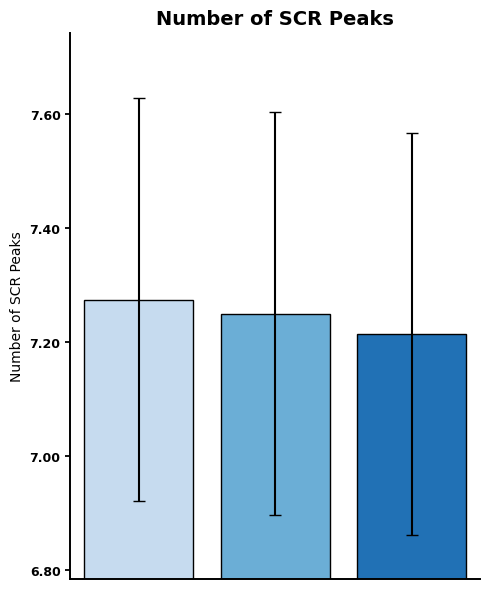

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Mean SCR Amplitude
Means for SCR_Peaks_Amplitude_Mean:
  H: 0.286
  L: 0.214
  M: 0.309

=== Mean SCR Amplitude (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -2082.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1169 -0.4361 -0.1012  0.4275  7.6534 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.06051  0.2460  
 Residual                   0.01603  0.1266  
Number of obs: 1782, groups:  participant_id, 40

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.152e-01  1.332e-01  3.800e+01   3.116  0.00348 ** 
condition.L            5.146e-02  5.205e-03  1.740e+03   9.886  < 2e-16 ***
condition.Q           -4.891e-02  5.193e-03  1.740e+03  -9.417  < 2e-16 ***
session_order

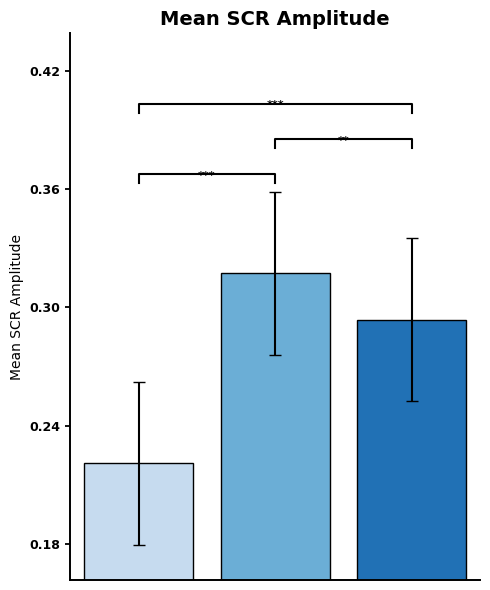

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Tonic Component SD
Means for EDA_Tonic_SD:
  H: 0.174
  L: 0.151
  M: 0.183

=== Tonic Component SD (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -3387.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7071 -0.5149 -0.1271  0.3415  5.8359 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.011742 0.10836 
 Residual                   0.007845 0.08857 
Number of obs: 1782, groups:  participant_id, 40

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.306e-01  5.896e-02  3.801e+01   3.911 0.000367 ***
condition.L            1.614e-02  3.642e-03  1.740e+03   4.432 9.92e-06 ***
condition.Q           -1.754e-02  3.633e-03  1.740e+03  -4.827 1.50e-06 ***
session_order_numeric -3.

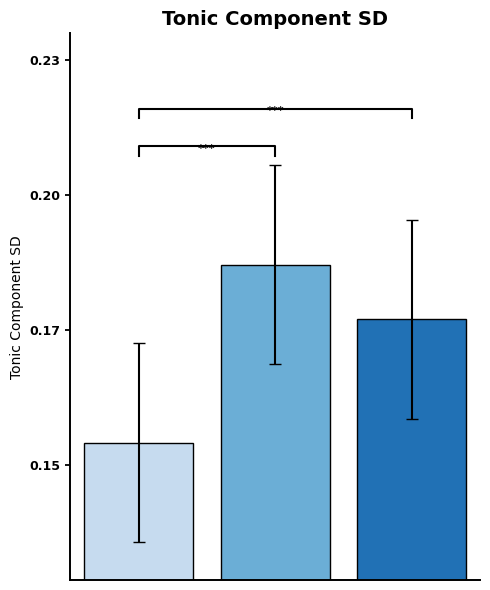

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



EDA Autocorrelation
Means for EDA_Autocorrelation:
  H: 0.351
  L: 0.372
  M: 0.347

=== EDA Autocorrelation (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -575.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1625 -0.6503  0.0576  0.6995  2.7200 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.02501  0.1581  
 Residual                   0.03882  0.1970  
Number of obs: 1782, groups:  participant_id, 40

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.871e-01  8.689e-02  3.803e+01   4.455 7.15e-05 ***
condition.L           -1.518e-02  8.101e-03  1.740e+03  -1.874   0.0611 .  
condition.Q            1.248e-02  8.083e-03  1.740e+03   1.545   0.1226    
session_order_num

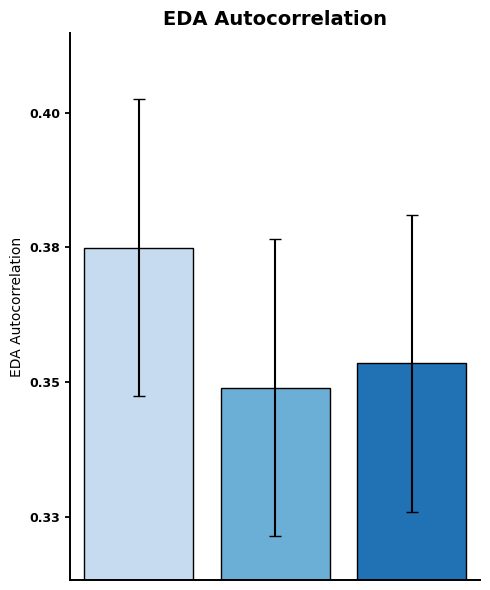


✓ Statistical analysis complete!


In [7]:
# Run statistical analysis for key EDA metrics
for metric, label in metrics:
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    
    # Run mixed effects model and get stats
    pairwise_p, means, cis = run_rpy2_lmer(
        all_features_df, metric, label
    )
    
    # Prepare data for plotting
    conds = ["L", "M", "H"]
    mean_vals = [means.get(c, float('nan')) for c in conds]
    sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
    pvals = [
        pairwise_p.get(("L", "M"), 1.0), 
        pairwise_p.get(("L", "H"), 1.0), 
        pairwise_p.get(("M", "H"), 1.0)
    ]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(5, 6))
    barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
    ax.set_title(label, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

print("\n✓ Statistical analysis complete!")